In [1]:
from skimage.io.collection import ImageCollection
from skimage.io import imread
from joblib import Parallel,delayed
from typing import Tuple, List
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt


In [2]:
"""
   Load images from DataBase and QuerySets
"""
def load_data() -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    db = ImageCollection("../data/BBDD/*.jpg")
    print('BBDD read: {} images'.format(len(db)))
    qs1 = ImageCollection("../data/qsd1_w1/*.jpg")
    print('QuerySet1 read: {} images'.format(len(qs1)))
    qs2 = ImageCollection("../data/qsd2_w1/*.jpg")
    print('QuerySet2 read: {} images'.format(len(qs2)))
    
    return db, qs1, qs2

In [3]:
"""
   Computes image's histograms for each color channel (r,g,b) and concatenates them
   to create a feature vector
"""
def get_histogram_vector(image: np.ndarray,n_bins: int = 16) -> np.ndarray:
   r_hist = np.histogram(image[:, :, 0],bins=n_bins)[0]
   g_hist = np.histogram(image[:, :, 1],bins=n_bins)[0]
   b_hist = np.histogram(image[:, :, 2],bins=n_bins)[0]
   feature_vector = np.hstack((r_hist,g_hist,b_hist))
   return feature_vector


"""
   Computes feature vector for each image of our dataset.
"""    
def get_feature_matrix(dataset: np.ndarray, desc: str, n_bins: int = 16) -> np.ndarray:
   feature_matrix = Parallel(n_jobs=2)(delayed(get_histogram_vector)(image,n_bins)for image in tqdm(dataset,desc=desc))
   return np.array(feature_matrix)  

In [4]:
"""
   Computes cos similarity between feature vector and all BBDD feature vectors
"""    
def cos_similarity(vector: np.ndarray) -> np.ndarray:
    return db_feature_matrix.dot(vector)/ (np.linalg.norm(db_feature_matrix, axis=1) * np.linalg.norm(vector))


"""
   Computes cos similairty for an entire QuerySet
"""    
def compute_similarities(qs: np.ndarray,desc: str) -> np.ndarray:
    return np.array([cos_similarity(vector) for vector in tqdm(qs,desc=desc)])

In [5]:
"""
   Retrieves the top k similar images for a vector.
"""    
def get_top_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
    idx = np.argpartition(similarity_vector, -k)[-k:]
    top_k = list(similarity_vector[idx])
    sorted_top = list(sorted(top_k,reverse=True))
    idx = [idx[top_k.index(i)] for i in sorted_top]
    return [db.files[i] for i in idx]


"""
   Retrieves the top k similar images for a QuerySEt
"""    
def get_top_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
    return [get_top_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]


"""
   Retrieves the top k similar images for a vector.
"""    
def get_bot_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
    idx = similarity_vector.argsort()[:k]
    bot_k = list(similarity_vector[idx])
    sorted_bot = list(sorted(bot_k,reverse=False))
    idx = [idx[bot_k.index(i)] for i in sorted_bot]
    return [db.files[i] for i in idx]


"""
   Retrieves the bot k similar images for a QuerySet.
"""    
def get_bot_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
    return [get_bot_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]

In [6]:
"""
   Plot Base Image and top 3 closest images
"""   
def plot_image_and_similar(image,similar):
    f, axarr = plt.subplots(2,2, figsize=(10,10))
    axarr[0,0].imshow(image)
    axarr[0,0].title.set_text("Base")
    axarr[0,1].imshow(similar[0])
    axarr[0,1].title.set_text("Query 1")
    axarr[1,0].imshow(similar[1])
    axarr[1,0].title.set_text("Query 2")
    axarr[1,1].imshow(similar[2])
    axarr[1,1].title.set_text("Query 3")

In [7]:
db, qs1, qs2 = load_data()

db_feature_matrix = get_feature_matrix(dataset = db, n_bins = 16, desc = "Creating feature matrix for BBDD...")
qs1_feature_matrix = get_feature_matrix(dataset = qs1, n_bins = 16, desc = "Creating feature matrix for QuerySet1...")
qs2_feature_matrix = get_feature_matrix(dataset = qs2, n_bins = 16, desc = "Creating feature matrix for QuerySet2...")

qs1_similarities = compute_similarities(qs = qs1_feature_matrix, desc = "Computing qs1 similarities...")
qs2_similarities = compute_similarities(qs = qs2_feature_matrix, desc = "Computing qs2 similarities...")

top_k_qs1 = get_top_k(qs1_similarities, 3, desc = "Retrieving qs1 top K similar images...")
top_k_qs2 = get_top_k(qs2_similarities, 3, desc = "Retrieving qs2 top K similar images...")

bot_k_qs1 = get_bot_k(qs1_similarities, 3, desc = "Retrieving qs1 bot K similar images...")
bot_k_qs2 = get_bot_k(qs2_similarities, 3, desc = "Retrieving qs2 bot K similar images...")

Creating feature matrix for BBDD...:   0%|          | 0/287 [00:00<?, ?it/s]

BBDD read: 287 images
QuerySet1 read: 30 images
QuerySet2 read: 30 images


Retrieving qs2 bot K similar images...: 100%|██████████| 30/30 [00:00<00:00, 26373.74it/s]


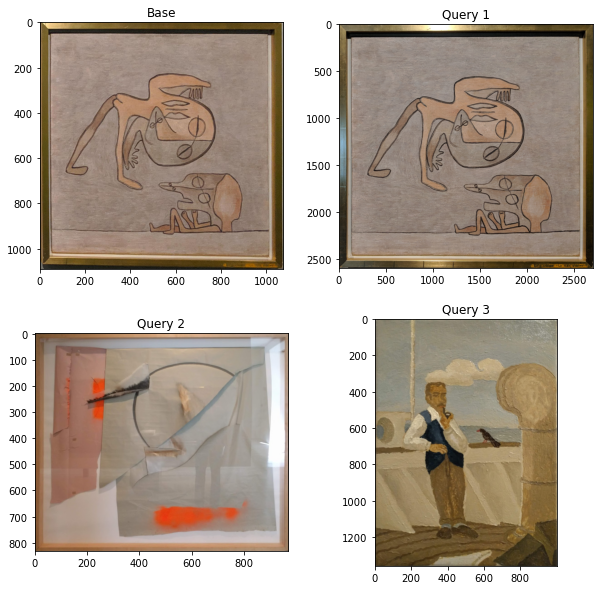

In [8]:
# Example plot 1
plot_image_and_similar(qs1[0],[imread(image) for image in top_k_qs1[0]])

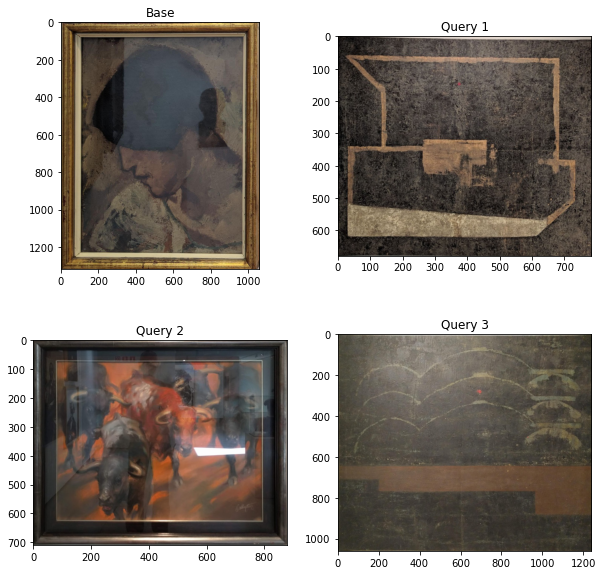

In [9]:
# Example plot 2
plot_image_and_similar(qs1[1],[imread(image) for image in top_k_qs1[1]])

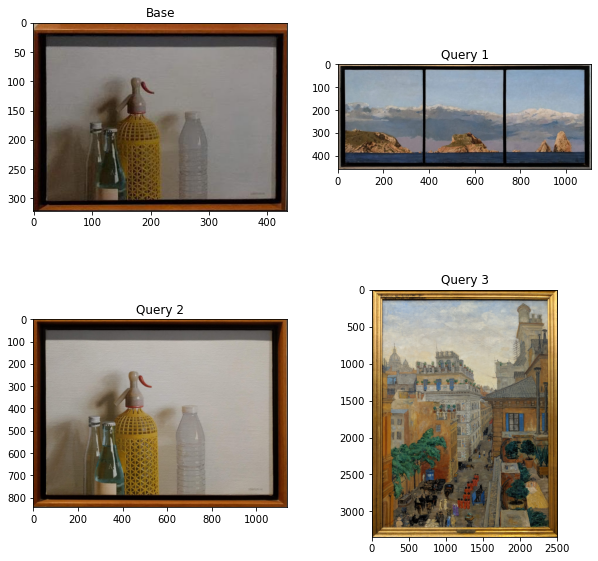

In [10]:
# Example plot 3
plot_image_and_similar(qs1[2],[imread(image) for image in top_k_qs1[2]])